# Algorytmy geometryczne - LAB 4
#### Triangulacja wielokątów monotonicznych

Konfiguracja

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import math

In [22]:
EPS = 1e-5

class Orientation:
    LEFT = 1
    COLINEAR = 2
    RIGHT = 3

def det(A, B, C):
    matrix = [[A[0],A[1],1],[B[0],B[1],1],[C[0],C[1],1]]
    det  = matrix[0][0] * matrix[1][1] * matrix[2][2]
    det += matrix[1][0] * matrix[2][1] * matrix[0][2]
    det += matrix[2][0] * matrix[0][1] * matrix[1][2]
    det -= matrix[0][2] * matrix[1][1] * matrix[2][0]
    det -= matrix[1][2] * matrix[2][1] * matrix[0][0]
    det -= matrix[2][2] * matrix[0][1] * matrix[1][0]
    return det

def orient(A, B, C, eps=EPS):
    detABC = det(A,B,C)
    if math.fabs(detABC) < eps: return Orientation.COLINEAR
    elif detABC > 0:            return Orientation.LEFT
    else:                       return Orientation.RIGHT

## Zadanie 1
#### Modyfikacja aplikacji graficznej

In [23]:
class BasicPointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker
        
class BasicLinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, [mcolors.to_rgba(self.color)] * len(lines))
        else:
            return mcoll.LineCollection(self.lines)

class BasicPlot:
    def __init__(self, points=[], lines=[], json = None):
        if json is None:
            self.points = points
            self.lines = lines
        else:
            self.points = [BasicPointsCollection(pointsCol) for pointsCol in js.loads(json)["points"]]
            self.lines = [BasicLinesCollection(linesCol) for linesCol in js.loads(json)["lines"]]
            
    def draw(self):
        ax = plt.axes()
        for collection in self.points:
            if collection.points.size > 0:
                ax.scatter(*zip(*collection.points), c=collection.color, marker=collection.marker)
        for collection in self.lines:
            ax.add_collection(collection.get_collection())
        ax.autoscale()
        plt.draw()
        
    def toJSON(self):
        return js.dumps({"points": [pointCol.points.tolist() for pointCol in self.points], 
                          "lines":[linesCol.lines for linesCol in self.lines]})

In [24]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

In [25]:
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        
        self.didpolygon = False
        self.polygon = PointsCollection()

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())
            
    def make_polygon(self, event):
        if self.didpolygon == True:                return
        if not self.added_points:                  return
        if len(self.added_points[-1].points) < 3:  return
        
        self.didpolygon = True
        
        if not self.added_lines:
            self.added_lines.append(LinesCollection())
        
        for a, b in self.added_points[-1].points:
            self.polygon.add_points([(a, b)])

        pre = (self.polygon.points[-1][0], self.polygon.points[-1][1])
        for a, b in self.polygon.points:
            self.added_lines[-1].add([pre, (a, b)])
            pre = (a, b)
        
        self.draw(autoscaling = False)

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [26]:
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_make_polygon = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        b_make_polygon = Button(ax_make_polygon, 'Wielokąt')
        b_make_polygon.on_clicked(callback.make_polygon)
        return [b_prev, b_next, b_add_point, b_add_line, b_make_polygon]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
        
    def get_added_polygon(self):
        if self.callback:
            return self.callback.polygon
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

In [27]:
class Visuals:
    @staticmethod
    def toLine(A, B):
        return [(A[0],A[1]),(B[0],B[1])]

    @staticmethod
    def drawTriangles(coords, triangles):
        coor_no = len(coords)
        sides = {}
        pCol = BasicPointsCollection([(x, y) for x, y in coords])
        lCol = BasicLinesCollection([])
        
        for a, b, c in triangles:
            if a < b: sides[(a, b)] = True
            else:     sides[(b, a)] = True
            if a < c: sides[(a, c)] = True
            else:     sides[(c, a)] = True
            if b < c: sides[(b, c)] = True
            else:     sides[(c, b)] = True
        
        for side in sides:
            lCol.add(Visuals.toLine(coords[side[0]], coords[side[1]]))
        
        plot = BasicPlot([pCol],[lCol])
        plot.draw()

<IPython.core.display.Javascript object>


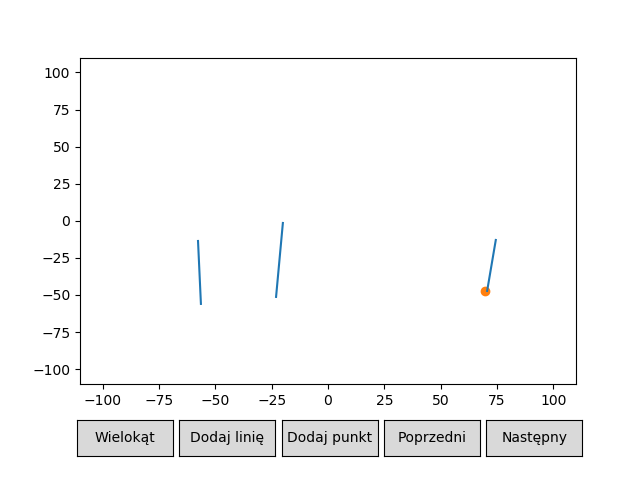

In [28]:
%matplotlib notebook

scenes = [Scene([PointsCollection([(-100,-100),(100,100)], s=0)],[LinesCollection([])])]

plot = Plot(scenes)
plot.draw() 

In [9]:
poly = plot.get_added_polygon()

## Zadanie 2
#### Sprawdzanie, czy wielokąt jest monotoniczny

In [10]:
def isYmonotone(pointcol):
    shifts = 0
    last = pointcol.points[-1][1]
    inc = False
    dec = False
    
    for _, y in pointcol.points:
        if math.fabs(last - y) < EPS: continue
        if not inc and y > last:
            inc = True
            dec = False
            shifts += 1
        if not dec and y < last:
            inc = False
            dec = True
            shifts += 1
    
    return shifts == 2

In [11]:
isYmonotone(poly)

IndexError: list index out of range

## Zadanie 3
#### Sprawdzanie, czy punkt jest: początkowy, końcowy, łączący, dzielący, prawidłowy 

####### 1. Początkowy: obaj sąsiedzi poniżej i kąt wewnętrzny < pi
####### 2. Końcowy:    obaj sąsiedzi powyżej i kąt wewnętrzny < pi
####### 3. Łączący:    obaj sąsiedzi powyżej i kąt wewnętrzny > pi
####### 4. Dzielący:   obaj sąsiedzi poniżej i kąt wewnętrzny > pi
####### 5. Prawidłowy: w przeciwnym przypadku (tj. jeden sąsiad powyżej, drugi poniżej)

In [ ]:
class PointType:
    INITIAL    = 1
    FINAL      = 2
    LINKING    = 3
    SEPARATING = 4
    PROPER     = 5

In [ ]:
def checkPointTypes(pointcol):
    pointTypes = [0]*len(pointcol.points)
    
    for i in range(len(pointcol.points)):
        a = pointcol.points[i-2]
        b = pointcol.points[i-1]
        c = pointcol.points[i]
        
        if   a[1] < b[1] and c[1] < b[1]:
            if orient(a, b, c) == Orientation.LEFT:
                pointTypes[i-1] = PointType.INITIAL
            else:
                pointTypes[i-1] = PointType.SEPARATING
        elif a[1] > b[1] and c[1] > b[1]:
            if orient(a, b, c) == Orientation.LEFT:
                pointTypes[i-1] = PointType.FINAL
            else:
                pointTypes[i-1] = PointType.LINKING
        else:
            pointTypes[i-1] = PointType.PROPER
    
    return pointTypes

In [ ]:
def visualizePointTypes(pointcol):
    pTypes = checkPointTypes(pointcol)
    
    lines = LinesCollection([])
    initial = PointsCollection([], color = 'lime')
    final = PointsCollection([], color = 'r')
    linking = PointsCollection([], color = 'dodgerblue')
    separating = PointsCollection([], color = 'c')
    proper = PointsCollection([], color = 'k')
    
    for i, point in enumerate(pointcol.points):
        lines.add([pointcol.points[i-1], point])
        if   pTypes[i] == 1: initial.add_points([point])
        elif pTypes[i] == 2: final.add_points([point])
        elif pTypes[i] == 3: linking.add_points([point])
        elif pTypes[i] == 4: separating.add_points([point])
        else:                proper.add_points([point])
    
    scene = [Scene([initial, final, linking, separating, proper], [lines])]
    plot_pt = Plot(scene)
    plot_pt.draw()

In [ ]:
visualizePointTypes(poly)

## Zadanie 4
#### Triangulacja trójkąta monotonicznego

In [ ]:
def findChains(pointcol):
    normed = list()
    
    m, maxym = 0, pointcol.points[0][1]
    n, minyn = 0, pointcol.points[0][1]
    length = len(pointcol.points)
    
    for i, (x, y) in enumerate(pointcol.points):
        if y > maxym:
            maxym = y
            m = i
        if y < minyn:
            minyn = y
            n = i
    
    print(m, n)
    
    normed.append((m, 0))
    # 0 - both chains
    # 1 - left chain
    # 2 - right chain
    i = m + 1
    j = m - 1
    
    while not (i%length == n and j%length == n):
        print(i, j)
        if pointcol.points[i%length][1] > pointcol.points[j][1]:
            normed.append((i%length, 1))
            i += 1
        else:
            normed.append((j, 2))
            j -= 1
    
    normed.append((n, 0))
    
    return normed

In [ ]:
def sameChain(normed, a, b):
    if (a[1] == 0 or a[1] == 1) and (b[1] == 0 or b[1] == 1): return 1
    if (a[1] == 0 or a[1] == 2) and (b[1] == 0 or b[1] == 2): return 2
    return -1

In [ ]:
def triangulateMono(pointcol):
    if not isYmonotone(pointcol):
        print("Polygon not monotone")
        return
    
    normed = findChains(pointcol)
    print(normed)
    
    triangles = {}
        
    stos = list()
    stos.append(normed.pop(0))
    stos.append(normed.pop(0))
    print(stos)
    
    while len(normed) > 0:
        nextPoint = normed.pop(0)
        print(nextPoint)
        
        if sameChain(normed, stos[-1], nextPoint) == -1:
            print("notsame")
            print(stos[-2][1], stos[-1][1], nextPoint[1])
            triangles[(stos[-2][0], stos[-1][0], nextPoint[0])] = True
            last = stos[-1]
            for i in range(1, len(stos)):
                triangles[(stos[i-1][0], stos[i][0], nextPoint[0])] = True
            stos.clear()
            stos.append(last)
            stos.append(nextPoint)
        else:
            print("same")
            last = stos[-1]
            
            while stos:
                break
                
            # to do
    
    for triangle in triangles:
        print(triangle)
        
    return triangles

In [ ]:
triangles = triangulateMono(poly)

In [ ]:
Visuals.drawTriangles(poly.points, triangles)

## Zadanie 5
#### Struktury

Wielokąt przechowuję jako listę jego kolejnych (idąc przeciwnie do wskazówek zegara) wierzchołków

Triangulację przechowuję jako słownik

## Zadanie 6
#### Treść